##### Initial segmentation will use the [MaskRCNN model with the ResNet-50-FCN](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html#torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights) and the [COCO dataset](https://cocodataset.org/#explore)

In [4]:
import cv2 as cv
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.COCO_V1
transforms = weights.transforms()

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()
categories = weights.meta["categories"]
print(model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

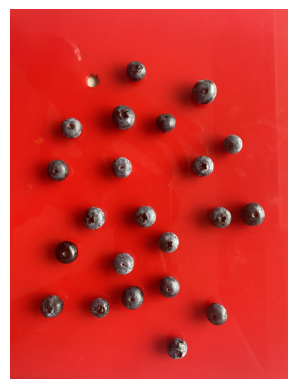

In [6]:
from PIL import Image
import matplotlib.pyplot as plt


# Map ripeness labels to colors
blueberry_colors = {
    'ripe': (0, 130, 200),  # Blue
    'overripe': (190, 60, 120),     # Pink
    'unripe': (0, 128, 0),  # Green
    'blueberry': (0,0,255), #BLUE
}

# Load a ripe image
image_path = '../image_set/ripe/ripe-1.png'
image = Image.open(image_path).convert("RGB")

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
# convert to a tensor and normalizes the data as well as shape of the image
preprocess = T.Compose([
    T.ToTensor(),
])
 # Preprocess the image
img_preprocess = preprocess(image).unsqueeze(0)

print(f'Shape of original image: {image.size}')
print(f'Shape of original image: {img_preprocess.shape}')

# Make a prediction
with torch.no_grad():
    predictions = model(img_preprocess)

# Extract boxes, labels, scores, and masks from predictions
boxes = predictions[0]['boxes'].cpu().detach().numpy()
labels = predictions[0]['labels'].cpu().detach().numpy()
scores = predictions[0]['scores'].cpu().detach().numpy()
masks = predictions[0]['masks'].cpu().detach().numpy()

masks = masks > 0.6  # Apply a threshold

Shape of original image: (3024, 4032)
Shape of original image: torch.Size([1, 3, 4032, 3024])


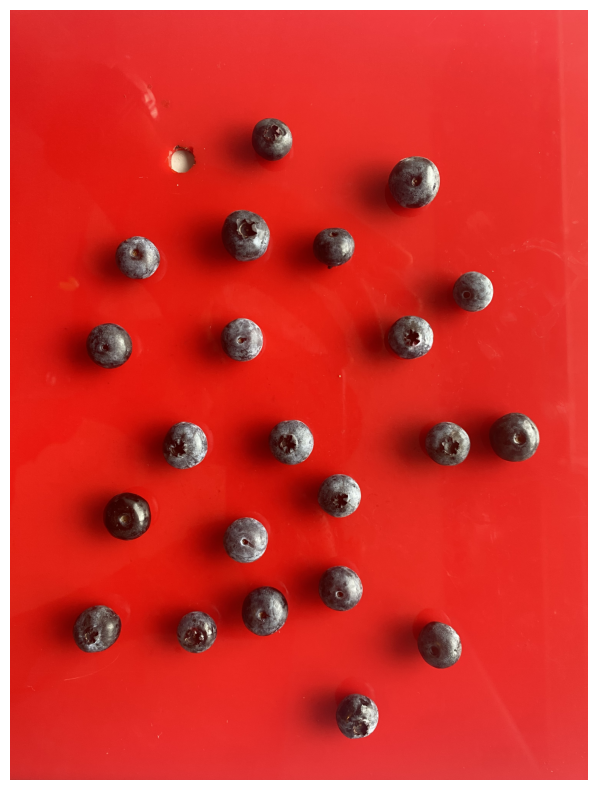

In [9]:

# Visualize the results
image_cv = cv.imread(image_path)
score_threshold = 0.6

for i in range(len(scores)):
    if scores[i] > score_threshold:
        # Get the label name
        label_name = categories[labels[i]]
        
        # Check if the label is in the fruit_colors mapping
        if label_name in blueberry_colors:
            color = blueberry_colors[label_name]
            
            # Resize the mask to the same size as the image
            mask = masks[i][0]
            mask = mask.astype(np.uint8)
            mask = cv.resize(mask, (image_cv.shape[1], image_cv.shape[0]))

            # Normalize mask values to [0, 255] for better visualization
            mask = (mask * 255).astype(np.uint8)

            # Create a colored mask for visualization
            colored_mask = np.zeros_like(image_cv)
            colored_mask[:, :, 0] = mask * (color[0] / 255)  # Blue channel
            colored_mask[:, :, 1] = mask * (color[1] / 255)  # Green channel
            colored_mask[:, :, 2] = mask * (color[2] / 255)  # Red channel

            # Apply the mask with transparency
            image_cv = cv.addWeighted(image_cv, 1, colored_mask, 0.5, 0)

            # Draw the bounding box
            cv.rectangle(image_cv, (int(boxes[i][0]), int(boxes[i][1])), 
                         (int(boxes[i][2]), int(boxes[i][3])), color, 2)

            # Calculate the center of the bounding box
            center_x = int((boxes[i][0] + boxes[i][2]) / 2)
            center_y = int((boxes[i][1] + boxes[i][3]) / 2)

            # Put the label text at the center of the bounding box
            cv.putText(image_cv, label_name, (center_x, center_y), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Plot the final image with masks and bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(image_cv, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()